Alumno: Samuel Schmidt
Alumno: David Schulz
Alumno: Bendeguz Szabo 

In [2]:
import zipfile
with zipfile.ZipFile("../input/xview-recognition/download","r") as z:
    z.extractall(".")

FileNotFoundError: [Errno 2] No such file or directory: '../input/xview-recognition/download'

In [3]:
IMAGE_FOLDER_PATH='/kaggle/working/xview_recognition/'

# Install

In [4]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [5]:
categories = {0: 'CARGO_PLANE', 1: 'HELICOPTER', 2: 'SMALL_CAR', 3: 'BUS', 4: 'TRUCK', 5: 'MOTORBOAT', 6: 'FISHING_VESSEL', 7: 'DUMP_TRUCK', 8: 'EXCAVATOR', 9: 'BUILDING', 10: 'STORAGE_TANK', 11: 'SHIPPING_CONTAINER'}

In [7]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

## Data augmentation version
import warnings
import rasterio
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, do_shuffle=False):
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                image = load_geoimage(filename)
                # Apply data augmentation
                image = datagen.random_transform(image)
                images.append(image)
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

# Training

In [20]:
import json

# Load database
json_file = IMAGE_FOLDER_PATH + 'xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/xview_recognition/xview_ann_train.json'

In [14]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage(IMAGE_FOLDER_PATH + json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'CARGO_PLANE': 635, 'HELICOPTER': 70, 'SMALL_CAR': 11675, 'BUS': 4017, 'TRUCK': 5836, 'MOTORBOAT': 571, 'FISHING_VESSEL': 457, 'DUMP_TRUCK': 1108, 'EXCAVATOR': 741, 'BUILDING': 13011, 'STORAGE_TANK': 1249, 'SHIPPING_CONTAINER': 816}


In [15]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)

In [19]:
# Load architecture
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Activation, BatchNormalization, Flatten
from keras.applications import MobileNetV3Small, ConvNeXtXLarge, ResNet50V2
from keras.utils import plot_model
base_model = ResNet50V2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
    classes=1000,
    pooling=None,
)
# Freeze the base_model
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(input_shape=(224, 224, 3)),
    Activation('relu'),
    Dropout(0.2),
    Dense(len(categories)),
    Activation('softmax')])

plot_model(model, to_file='resnet50v2.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [31]:
from keras.optimizers import Adam

# Learning rate is changed to 0.001
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.00, amsgrad=True, clipnorm=1.0, clipvalue=0.5)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [32]:
from keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [33]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 64
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [34]:
import math
import numpy as np
print('Training model')
epochs = 20
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit_generator(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
565/566 [============================>.] - ETA: 0s - loss: 194.7571 - accuracy: 0.4300
Epoch 1: val_accuracy improved from -inf to 0.45210, saving model to model.hdf5
566/566 [==============================] - 157s 273ms/step - loss: 194.7374 - accuracy: 0.4300 - val_loss: 276.1096 - val_accuracy: 0.4521 - lr: 0.0010
Epoch 2/20
565/566 [============================>.] - ETA: 0s - loss: 178.3212 - accuracy: 0.5092
Epoch 2: val_accuracy improved from 0.45210 to 0.59816, saving model to model.hdf5
566/566 [==============================] - 151s 267ms/step - loss: 178.2972 - accuracy: 0.5092 - val_loss: 203.2499 - val_accuracy: 0.5982 - lr: 0.0010
Epoch 3/20
565/566 [============================>.] - ETA: 0s - loss: 178.3959 - accuracy: 0.5432
Epoch 3: val_accuracy did not improve from 0.59816
566/566 [==============================] - 153s 271ms/step - loss: 178.4071 - accuracy: 0.5433 - val_loss: 233.6958 - val_accuracy: 0.3789 - lr: 0.0010
Epoch 4/20
565/566 [================

## Fine tuning

In [ ]:
base_model.trainable = True
model.summary()

from keras.optimizers import Adam

# Learning rate is made significantly smaller
opt2 = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.00, amsgrad=True, clipnorm=1.0, clipvalue=0.5)
model.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'])

import math
import numpy as np
print('Fine tuning model')
epochs = 10
h2 = model.fit_generator(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h2.history['val_accuracy']))
best_value = np.max(h2.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

# Testing

In [35]:
import json

# Load database
json_file = IMAGE_FOLDER_PATH + 'xview_ann_test.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [36]:
import numpy as np

anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage(IMAGE_FOLDER_PATH + json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    image.add_object(obj)
    anns.append(image)

In [37]:
import numpy as np

# model.load_weights('model.hdf5', by_name=True)
y_true, y_pred = [], []
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

1/1 [==============================] - 0s 23ms/step


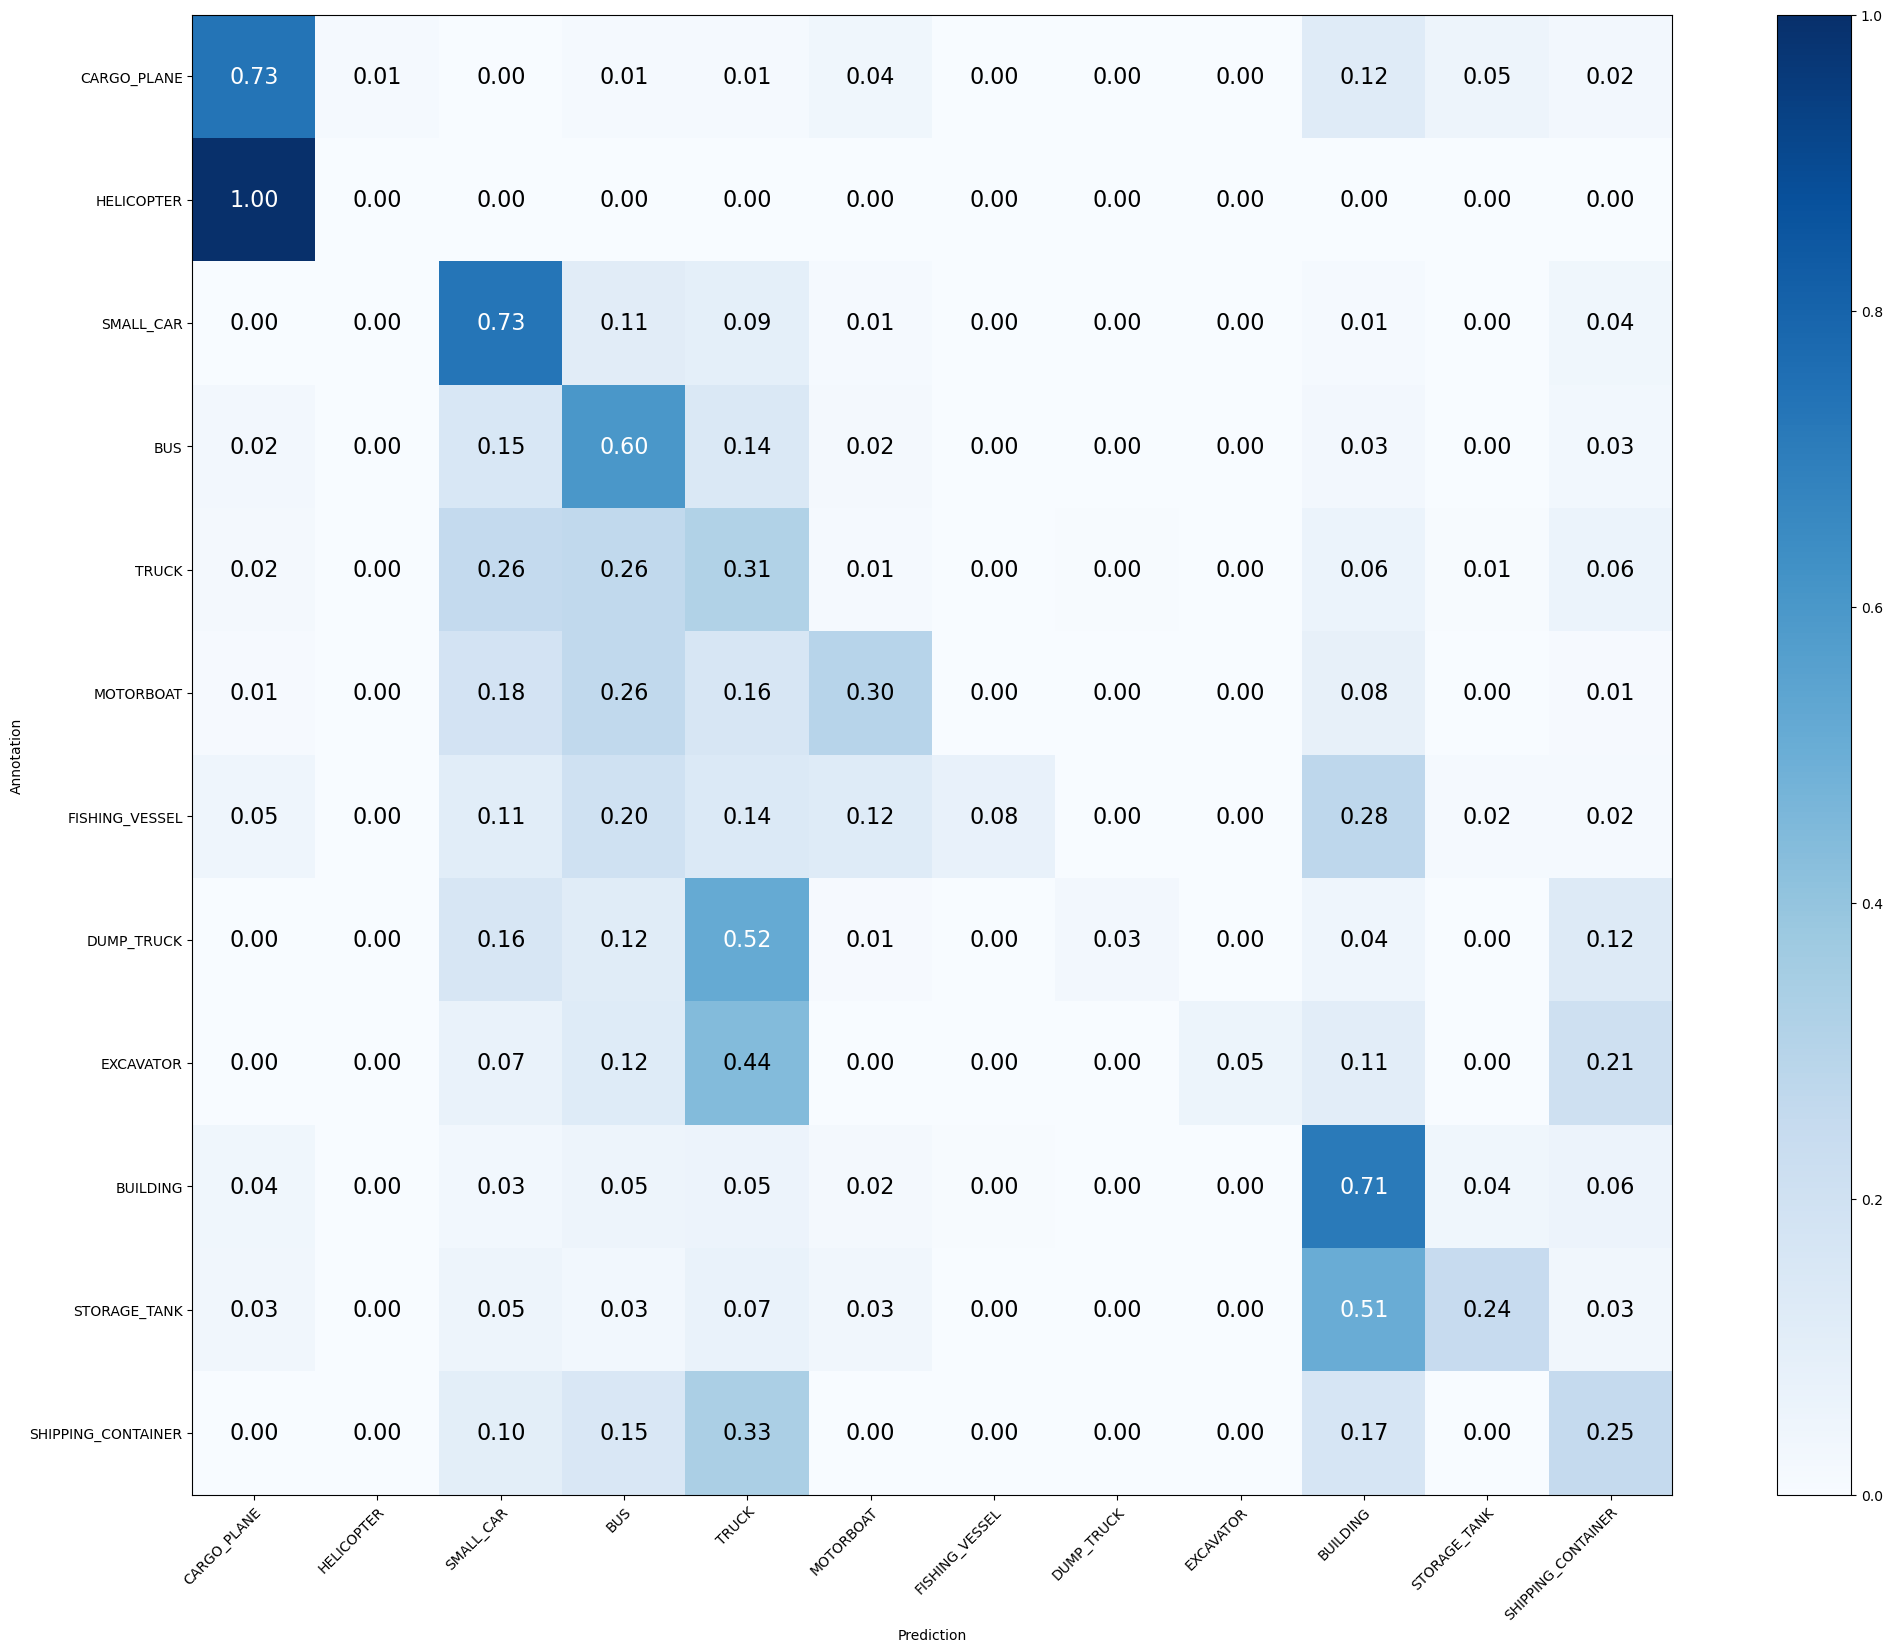

In [38]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [39]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 58.698%
Mean Recall: 33.652%
Mean Precision: 43.235%
> CARGO_PLANE: Recall: 73.494% Precision: 40.667% Specificity: 98.104% Dice: 52.361%
> HELICOPTER: Recall: 0.000% Precision: 0.000% Specificity: 99.916% Dice: 0.000%
> SMALL_CAR: Recall: 73.403% Precision: 74.700% Specificity: 89.272% Dice: 74.046%
> BUS: Recall: 59.956% Precision: 35.425% Specificity: 88.578% Dice: 44.536%
> TRUCK: Recall: 31.367% Precision: 33.851% Specificity: 89.564% Dice: 32.562%
> MOTORBOAT: Recall: 29.508% Precision: 29.268% Specificity: 98.131% Dice: 29.388%
> FISHING_VESSEL: Recall: 7.692% Precision: 38.462% Specificity: 99.830% Dice: 12.821%
> DUMP_TRUCK: Recall: 2.679% Precision: 42.857% Specificity: 99.914% Dice: 5.042%
> EXCAVATOR: Recall: 5.263% Precision: 100.000% Specificity: 100.000% Dice: 10.000%
> BUILDING: Recall: 71.151% Precision: 84.421% Specificity: 93.717% Dice: 77.220%
> STORAGE_TANK: Recall: 24.306% Precision: 33.019% Specificity: 98.468% Dice: 28.000%
> SHIPPING_CONTAINER: R

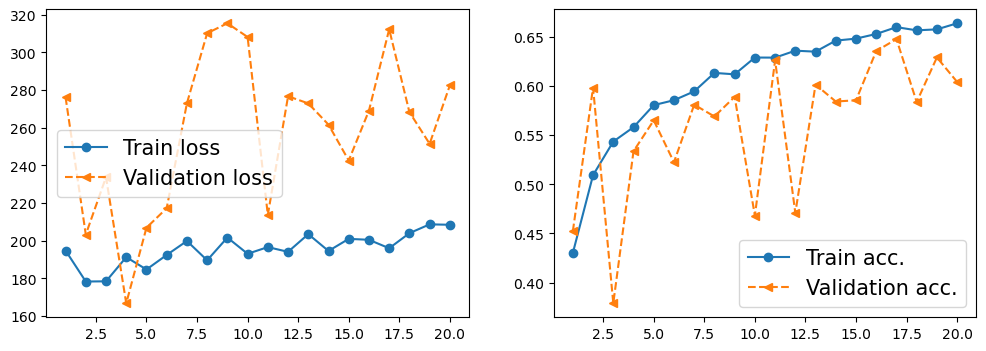

In [40]:
import matplotlib.pyplot as plt
hist = h.history
x_arr = np.arange(len(hist['loss'])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15) 
plt.show()